In [2]:
import numpy as np
import matplotlib.pyplot as plt
import imageio as io

import math

# 1. Rotação

In [1]:
def rotate(img, ang):
    
    ang = ang*(np.pi/180) #converte de graus para radiano
    r, c = img.shape[0:2] #r = n linhas, c = n colunas
    #desconsidera a linha e a coluna extra adicionadas
    r -= 1
    c -= 1
    #coordenadas do centro da imagem, para rotacionar em volta dele
    ic = r/2
    jc = c/2
    #imagem rotacionada iniciada com zeros. Dimensoes são tais para poder abrigar o maior
    #retangulo rotacionado possível (ang = 45)
    r_rot = int(round(r*np.sqrt(2)))
    c_rot = int(round(c*np.sqrt(2)))
    M_rot = np.zeros((r_rot, c_rot, 3),dtype='uint8')
    #usados para centralizar a imagem rotacionada na imagem de destino, para evitar que 
    #alguns pixels fiquem com indice negativo
    i_cntrlz = int(round((r_rot-r)/2))
    j_cntrlz = int(round((c_rot-c)/2))
    #mapeamento reverso
    M_rev = np.zeros((r,c,3),dtype='uint8')
    M_rot_rev = np.zeros((r_rot, c_rot, 3),dtype='uint8')
    
    for i in range(r):
        for j in range(c):
            ##################### mapeamento direto ########################
            il = int(round((i-ic)*np.cos(-ang) - (j-jc)*np.sin(-ang) + ic))
            jl = int(round((i-ic)*np.sin(-ang) + (j-jc)*np.cos(-ang) + jc))
            #centralizar
            il += i_cntrlz
            jl += j_cntrlz
            #tons de cinza
            M_rot[il,jl,0] = img[i,j,0]
            M_rot[il,jl,1] = M_rot[il,jl,0]
            M_rot[il,jl,2] = M_rot[il,jl,0]
            
            ##################### mapeamento reverso ########################
            il = int(round((i-ic)*np.cos(-ang) - (j-jc)*np.sin(-ang) + ic))
            jl = int(round((i-ic)*np.sin(-ang) + (j-jc)*np.cos(-ang) + jc))
            x = (il-ic)*np.cos(-ang) + (jl-jc)*np.sin(-ang) + ic
            y = (-1*(il-ic))*np.sin(-ang) + (jl-jc)*np.cos(-ang) + jc
            #montagem do retangulo para realizar a interpolacao bilinear - coordenadas eixo x
            if x < 0:
                x = 0
            if x<i and x>0:
                ii = i-1
            elif x >= i:
                ii = i
            #montagem do retangulo para realizar a interpolacao bilinear - coordenadas eixo y    
            if y < 0:
                y = 0
            if y < j and y > 0:
                jj = j-1
            elif y >= j:
                jj = j
            #interpolacao bilinear
            i_y = img[ii,jj,0] + (y-jj)*(img[ii,jj+1,0] - img[ii,jj,0])
            i_mais_um_y = img[ii+1,jj,0] + (y-jj)*(img[ii+1,jj+1,0] - img[ii+1,jj,0])
            P = i_y + (x-ii)*(i_mais_um_y-i_y)
            #tons de cinza
            M_rev[i,j,0] = P
            M_rev[i,j,1] = M_rev[i,j,0]
            M_rev[i,j,2] = M_rev[i,j,0]
            ############ rotacao apos mapeamento reverso ##############
            #centralizar
            il += i_cntrlz
            jl += j_cntrlz
            #tons de cinza
            M_rot_rev[il,jl,0] = M_rev[i,j,0]
            M_rot_rev[il,jl,1] = M_rot_rev[il,jl,0]
            M_rot_rev[il,jl,2] = M_rot_rev[il,jl,0]
            
    return M_rot, M_rot_rev, M_rev

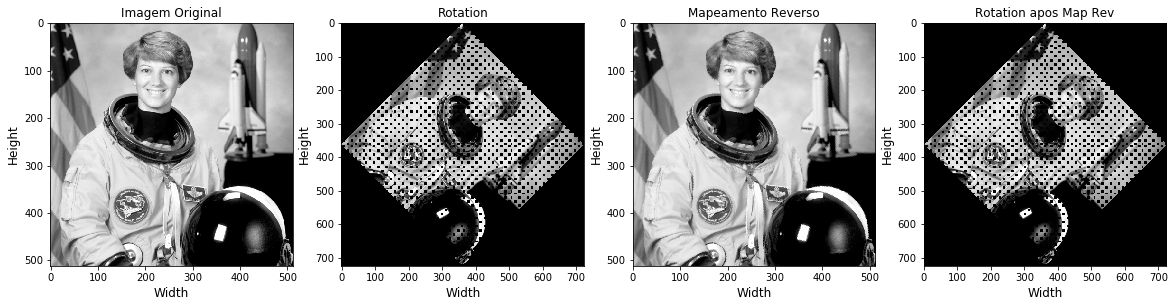

In [3]:
img = io.imread("imageio:astronaut.png")
#tons de cinza
img[:,:,1] = img[:,:,0]
img[:,:,2] = img[:,:,0]

#adiciona uma linha e uma coluna na imagem para auxiliar no mapeamento reverso
img_aux = np.zeros((img.shape[0]+1, img.shape[1]+1, 3))
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        for band in range(3):
            img_aux[i,j,band] = img[i,j,0]
        
M_rot, M_rot_rev, M_rev = rotate(img_aux, 45)

fig, ax = plt.subplots(1, 4, figsize = (20, 5))

ax[0].set_title('Imagem Original', fontsize=12)
ax[0].set_ylabel('Height', fontsize=12)
ax[0].set_xlabel('Width', fontsize=12)
ax[0].imshow(img)

ax[1].set_title('Rotation', fontsize=12)
ax[1].set_ylabel('Height', fontsize=12)
ax[1].set_xlabel('Width', fontsize=12)
ax[1].imshow(M_rot)

ax[2].set_title('Mapeamento Reverso', fontsize=12)
ax[2].set_ylabel('Height', fontsize=12)
ax[2].set_xlabel('Width', fontsize=12)
ax[2].imshow(M_rev)

ax[3].set_title('Rotation apos Map Rev', fontsize=12)
ax[3].set_ylabel('Height', fontsize=12)
ax[3].set_xlabel('Width', fontsize=12)
ax[3].imshow(M_rot_rev)

## 2. DCT

In [4]:
def DCT1D(x):
    N = len(x)
    X = np.zeros(N)
    Ak = math.sqrt(2.0/N)
    nn = 2.0 * N

    for k in range(N):
        ck = math.sqrt(0.5) if k == 0 else 1
        somatorio = 0

        for n in range(N):
            termo1 = 2.0 * math.pi * k * n
            termo2 = k * math.pi

            somatorio += x[n] * math.cos((termo1 + termo2)/nn)

        X[k] = Ak * ck * somatorio

    return X

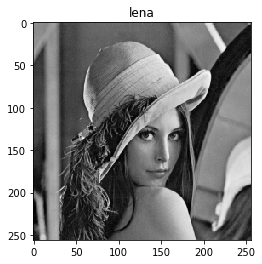

In [5]:
img = io.imread("lena.bmp")
img = np.asarray(img)
plt.imshow(img, cmap="gray")
plt.title("lena")
plt.show()

In [6]:
def IDCT1D(X):
#     N = len(X) # tamanho do vetor
#     x = np.zeros(N) # aloca o vetor
    
#     # variaveis auxiliares
#     c0 = math.sqrt(0.5) # valor de ck para k = 0
#     coef2 = math.sqrt(2 / N) # valor do outro coeficiente externo ao somatorio
#     pi = math.pi # valor de pi
    
#     for n in range(N):
#         sum = 0
#         # termos do cosseno
#         term1 = (pi * n) / N
#         term2 = pi / (N << 1)
#         for k in range(N):
#             if X[k] != 0: # economia de operacoes
#                 if k == 0:
#                     sum += (c0 * X[k] * math.cos(term1 * k + term2 * k))
#                 else:
#                     sum += X[k] * math.cos(term1 * k + term2 * k)
                    
#         sum *= coef2
#         x[n] = sum
        
#     return x
    
    
    
    
    N = len(X)
    x = np.zeros(N)
    Ak = math.sqrt(2.0/N)
    nn = 2.0 * N
    
    for n in range(N):
        somatorio = 0
        for k in range(N):
            termo1 = 2.0 * math.pi * k * n
            termo2 = k * math.pi
            ck = math.sqrt(1.0/2.0) if k == 0 else 1
                
            somatorio += ck * X[k] * math.cos((termo1 + termo2)/nn)
            
        x[n] = Ak * somatorio
    
    return x

In [7]:
def DCT2D(img, reverso):
    
    imgDCT = np.zeros(img.shape)

    for i, linha in enumerate(img):
        if reverso == False:
            imgDCT[i] = DCT1D(linha)
        else:
            imgDCT[i] = IDCT1D(linha)

    imgDCT = imgDCT.T #pega transposta

    for j, coluna in enumerate(imgDCT):
        if reverso == False:
            imgDCT[j] = DCT1D(coluna)
        else:
            imgDCT[j] = IDCT1D(coluna)
            
    imgDCT = imgDCT.T
    
    return imgDCT

Nível DC: 25261.12890625001


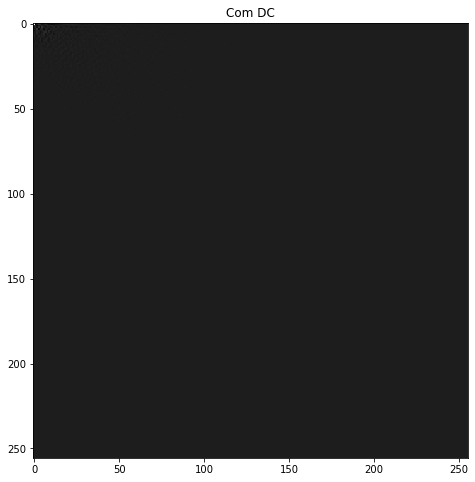

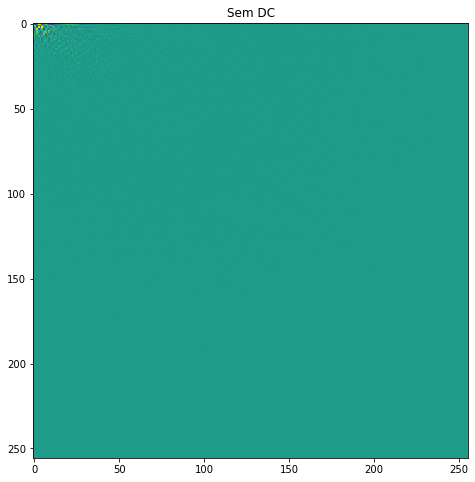

In [8]:
imgDCT = DCT2D(img, False)
dc = imgDCT[0][0]
print(f"Nível DC: {dc}")

plt.figure(figsize=[80,8])
plt.imshow(imgDCT, cmap="gray")
plt.title("Com DC")
plt.show()


imgDCT[0][0] = 0
plt.figure(figsize=[80,8])
plt.title("Sem DC")
plt.imshow(imgDCT)

25261.12890625001


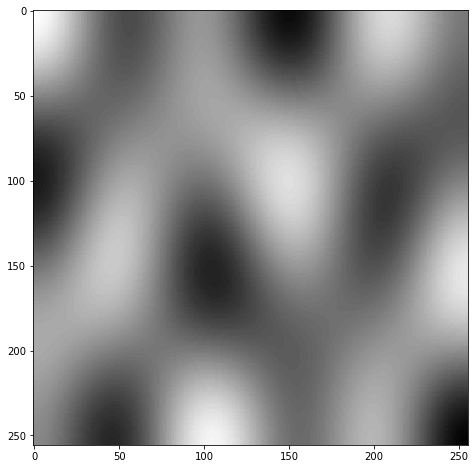

In [9]:
def aproximar(n):
    dct = np.zeros(img.shape)
    dct = DCT2D(img, False)
    dc = dct[0][0]
    # dicionário para os coeficientes
    coef = []
    if n > 0:
        for i in range(len(dct)):
            for j in range(len(dct[0])):
                if i != 0 and j != 0:
                    coef.append({"abs(Value)": abs(dct[i][j]), "Value": dct[i][j], "i": i, "j": j})
        # ordena de forma decrescente pelo valor absoluto, pois pode ter valores negativos
        coefOrdenados = sorted(coef, key = lambda z: z['abs(Value)'], reverse=True)
        # pega os n maiores valores
        maioresCoef = coefOrdenados[:n]
        # zera os coeficientes
        dct.fill(0)

        for c in maioresCoef:
            dct[c['i']][c['j']] = c['Value']
    else:
        dct.fill(0) # manter apenas o dc
    # adiciona dc      
    dct[0][0] = dc
    print(dc)
    
    imgAproximada = DCT2D(dct, True)

    return np.uint8(imgAproximada)


i = np.zeros(img.shape)
i = aproximar(2)
plt.figure(figsize=[80,8])
plt.imshow(i, cmap='gray')
plt.show()